# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles.<br/>
October 2017

## Basic setup to run this yourself at NERSC ##

On cori.nersc.gov, clone two_percent_DESI:
```
git clone https://github.com/desihub/two_percent_DESI
```
At the time of this writing, this notebook is still in the "minitest" branch so switch to that:
```
cd two_percent_DESI
git checkout minitest
```
This notebook and its configuration files are in `two_percent_DESI/mini`.

Configure the desi-17.9 jupyter notebook kernel for your account following the instructions at
https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC.  Then go to https://jupyter-dev.nersc.gov,
navigate to where you checked out `two_percent_DESI/mini` and start your own copy of this notebook.

To get the same version of code with an interactive login:
```console
source /project/projectdirs/desi/software/desi_environment.sh 17.9
```
(or `desi_environment.csh` for t/csh users)

### Notebook + Interactive Batch Jobs ###

Many steps are run directly in this notebook.  Some steps are slow enough that they benefit from using all the cores on 10-15 nodes.  In these cases, the notebook prints the commands for you to run from within an interactive batch session at NERSC.  The intension is that all steps can be run within an hour or so, but it isn't as simple as just Cell -> Run All.

In [1]:
import os, sys, glob
import numpy as np
import healpy as hp
from astropy.table import Table
import fitsio
import desimodel.io
import desimodel.footprint
import subprocess
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Set some environment variables and create output directories

The next cell will create directories under `$SCRATCH/desi/dev/end2end/` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |


In [2]:
basedir = os.getenv('SCRATCH')+'/desi/dev/end2end'
surveydir = os.environ['DESISURVEY_OUTPUT'] = basedir+'/survey'
targetdir = basedir+'/targets'
fibassigndir = basedir+'/fiberassign'

os.environ['DESI_SPECTRO_REDUX'] = basedir+'/spectro/redux'
os.environ['DESI_SPECTRO_SIM'] = basedir+'/spectro/sim'
os.environ['PIXPROD'] = 'mini'
os.environ['SPECPROD'] = 'mini'

reduxdir = os.path.join(os.getenv('DESI_SPECTRO_REDUX'), os.getenv('SPECPROD'))
simdatadir = os.path.join(os.getenv('DESI_SPECTRO_SIM'), os.getenv('PIXPROD'))
os.environ['DESI_SPECTRO_DATA'] = simdatadir

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

envcmd = """\
source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=$SCRATCH/desi/dev/end2end
export DESISURVEY_OUTPUT=$basedir/survey
export DESI_SPECTRO_REDUX=$basedir/spectro/redux
export DESI_SPECTRO_SIM=$basedir/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=$DESI_SPECTRO_SIM/$PIXPROD
"""
print('To recreate this environment from a login terminal:\n')
print(envcmd)

To recreate this environment from a login terminal:

source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=$SCRATCH/desi/dev/end2end
export DESISURVEY_OUTPUT=$basedir/survey
export DESI_SPECTRO_REDUX=$basedir/spectro/redux
export DESI_SPECTRO_SIM=$basedir/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=$DESI_SPECTRO_SIM/$PIXPROD



## Run survey simulations on a subset of tiles

This will select a test subset of tiles in the NGC and run survey simulations for observations during March 2020.  These steps should take <5 minutes to run.

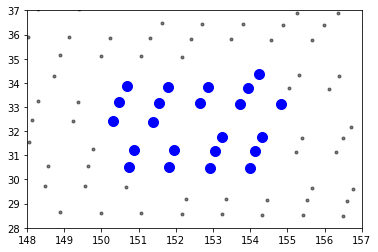

In [5]:
#- Make a subset of tiles to use
tiles = Table(desimodel.io.load_tiles())
ii = (150 < tiles['RA']) & (tiles['RA']<155) & (30<tiles['DEC']) & (tiles['DEC']<35)
clf()
plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.5)
plot(tiles['RA'][ii], tiles['DEC'][ii], 'bo', ms=10)
xlim(148, 157); ylim(28, 37)
tiles_subset = tiles[ii]
tiles[ii].write('tiles-subset.fits', overwrite=True)

In [4]:
!time surveyinit --config-file ./desisurvey-config.yaml


real	0m10.916s
user	0m9.587s
sys	0m0.569s


In [5]:
#- Use 0d fiber assignment delay to move on with mini sim quickly
!time surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --create --fa-delay 0d


real	0m2.098s
user	0m1.574s
sys	0m0.497s


In [6]:
!time surveysim --config-file ./desisurvey-config.yaml --seed 123 >> $surveydir/survey.log


real	0m17.310s
user	0m16.827s
sys	0m0.429s


In [7]:
import subprocess
import time
plan_cmd = 'surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --fa-delay 0d'
sim_cmd = 'surveysim --resume --config-file ./desisurvey-config.yaml --seed 123'
with open(os.path.join(surveydir, 'survey.log'), 'a') as logfile:
    while True:
        lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
        progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
        ndone = np.count_nonzero(progress['status'] == 2)
        print('Starting {} with {}/{} tiles completed {}'.format(lastdate, ndone, len(progress), time.asctime()))
        if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
            break
        if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
            break

print('done observing all tiles')

Starting 2020-03-16 with 7/22 tiles completed Thu Oct  5 15:20:26 2017
Starting 2020-03-17 with 11/22 tiles completed Thu Oct  5 15:20:31 2017
Starting 2020-03-18 with 11/22 tiles completed Thu Oct  5 15:20:36 2017
Starting 2020-03-19 with 15/22 tiles completed Thu Oct  5 15:20:59 2017
Starting 2020-03-20 with 19/22 tiles completed Thu Oct  5 15:21:04 2017
Starting 2020-03-21 with 20/22 tiles completed Thu Oct  5 15:21:29 2017
Starting 2020-03-22 with 21/22 tiles completed Thu Oct  5 15:21:55 2017
Starting 2020-03-23 with 22/22 tiles completed Thu Oct  5 15:22:00 2017
done observing all tiles


In [8]:
!ls $surveydir

ephem_2020-03-15_2020-04-15.fits  plan_2020-03-21.fits
last_date.txt			  plan_2020-03-22.fits
plan.fits			  progress.fits
plan_2020-03-15.fits		  progress_2020-03-16_bookmark.fits
plan_2020-03-16.fits		  progress_2020-03-17_bookmark.fits
plan_2020-03-16_bookmark.fits	  progress_2020-03-19_bookmark.fits
plan_2020-03-17.fits		  progress_2020-03-20_bookmark.fits
plan_2020-03-17_bookmark.fits	  scheduler.fits
plan_2020-03-18.fits		  stats.fits
plan_2020-03-19.fits		  survey.log
plan_2020-03-19_bookmark.fits	  surveyinit.fits
plan_2020-03-20.fits		  weather_123.fits
plan_2020-03-20_bookmark.fits


### Convert progress.fits -> exposures.fits
progress.fits is one row per tile; convert that into a file with one row per exposure.

In [3]:
from desisurvey.progress import Progress
p = Progress(restore='progress.fits')
explist = p.get_exposures()
explist.write(os.path.join(surveydir, 'exposures.fits'), overwrite=True)

INFO:progress.py:133:__init__: Loaded progress from /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/progress.fits.


In [6]:
# Sanity check
assert np.all(np.in1d(tiles_subset['TILEID'], explist['tileid']))

## Study which healpixels cover those tiles

In [11]:
isbright = explist['pass'] > 4
isgray = explist['pass'] == 4
isdark = explist['pass'] < 4
istwilight = isbright & (explist['moonalt'] < 0)

(28, 37)

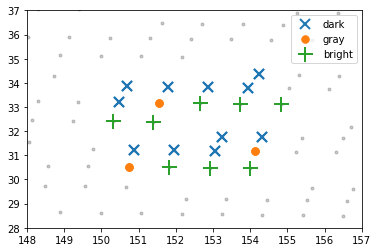

In [12]:
plot(tiles['RA'], tiles['DEC'], 'k.', alpha=0.2, label='_none_')
plot(explist['ra'][isdark], explist['dec'][isdark], 'x', ms=10, mew=2, label='dark')
plot(explist['ra'][isgray], explist['dec'][isgray], '.', ms=15, label='gray')
plot(explist['ra'][isbright], explist['dec'][isbright], '+', ms=15, mew=2, label='bright')
legend(loc='upper right')
xlim(148, 157); ylim(28, 37)

In [13]:
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, tiles_subset)
nexp = np.count_nonzero(np.in1d(explist['tileid'], tiles_subset['TILEID']) & ~istwilight)
print('{} tiles covered by {} exposures and {} healpixels'.format(len(tiles_subset), nexp, len(pixels)))

22 tiles covered by 28 exposures and 71 healpixels


In [14]:
pixels

array([5261, 5262, 5263, 5265, 5266, 5267, 5268, 5270, 5271, 5272, 5273,
       5274, 5275, 5276, 5277, 5278, 5279, 5281, 5283, 5284, 5285, 5286,
       5287, 5289, 5292, 5293, 5294, 5295, 5296, 5297, 5298, 5299, 5300,
       5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311,
       5314, 5320, 5321, 5322, 5323, 5324, 5326, 5344, 5345, 5346, 5347,
       5348, 5350, 5352, 5353, 5354, 5355, 5356, 5636, 5637, 5648, 5649,
       5650, 5651, 5652, 5653, 5654])

(28, 37)

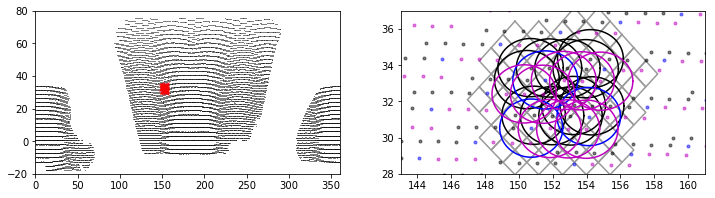

In [15]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plot(ra, dec, '-', color='0.6')

xtiles = tiles_subset
figure(figsize=(12,3))
subplot(121)
plot(tiles['RA'], tiles['DEC'], 'k,', alpha=0.5)
plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plot(xtiles['RA'], xtiles['DEC'], 'rx')
xlim(0,360); ylim(-20, 80)

subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = xtiles['PROGRAM'] == program
    for t in xtiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

xlim(143, 161); ylim(28, 37)

## Run select_mock_targets

This step combines mock catalogs with spectral templates per covered healpixel.
This notebook prints the commands to run in a separate cori login terminal to
get a 15 node interactive job, and then run the `mpi_select_mock_targets` command.
It should take ~15 minutes on 15 nodes.

In [21]:
#- Write subset of tiles table to file for input to mpi_select_mock_targets
tilefile = targetdir+'/test-tiles.fits'
Table(xtiles).write(tilefile, overwrite=True)
Table(xtiles)

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
1148,154.23,34.35,0,1,0.0148942,1.02536,1397.33,1.12968,DARK,1
1149,153.23,31.77,0,1,0.0207369,1.0252,1372.21,1.17033,DARK,1
1165,150.69,33.86,0,1,0.0126537,1.02517,1416.73,1.11412,DARK,1
6911,154.32,31.75,1,1,0.0229261,1.02521,1401.19,1.18603,DARK,1
6927,151.78,33.84,1,1,0.0134791,1.02517,1402.3,1.11972,DARK,1
11108,150.87,31.23,1,1,0.0189035,1.02543,1451.67,1.15767,DARK,1
12689,152.87,33.82,2,1,0.0149298,1.02516,1390.24,1.12964,DARK,1
16870,151.96,31.21,2,1,0.0207586,1.02544,1403.42,1.17082,DARK,1
18451,153.95,33.8,3,1,0.0170573,1.02516,1406.78,1.14435,DARK,1


In [26]:
cmd = "srun -N 15 -n 30 -c 16 " # -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets --output_dir {targetdir} --config select-mock-targets.yaml"
cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
cmd = cmd.format(targetdir=targetdir, tilefile=tilefile)
print('# on cori.nersc.gov:')
print('# cd to where ever you have two_percent_DESI/mini, then...\n')
print(envcmd)
print('salloc -N 15 -t 00:30:00 -C haswell --qos interactive')
print(cmd)

# on cori.nersc.gov:
# cd to where ever you have two_percent_DESI/mini, then...

source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=$SCRATCH/desi/dev/end2end
export DESISURVEY_OUTPUT=$basedir/survey
export DESI_SPECTRO_REDUX=$basedir/spectro/redux
export DESI_SPECTRO_SIM=$basedir/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=$DESI_SPECTRO_SIM/$PIXPROD

salloc -N 15 -t 00:30:00 -C haswell --qos interactive
srun -N 15 -n 30 -c 16  mpi_select_mock_targets --output_dir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --config select-mock-targets.yaml --seed 1 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/test-tiles.fits


## Check that we got the right number of target output files ##
The number of files of each type should match the number of healpixels

In [34]:
import glob
print("{} healpixels".format(len(pixels)))
for filetype in ['target', 'truth', 'sky', 'standards-dark', 'standards-bright']:
    filenames = glob.glob(targetdir+'/*/*/{}*.fits'.format(filetype))
    print('{} {} files'.format(len(filenames), filetype))

71 healpixels
71 target files
71 truth files
71 sky files
71 standards-dark files
71 standards-bright files


## Merge target, sky, and stdstar catalogs

mpi_select_mock_targets writes targets per healpixel.  This step combines them into full catalogs (but the truth spectra themselves are still kept in individual healpix-organized files, otherwise they would be too big).
It also generates the "Merged Target List" (mtl) that assigns priorities to targets for fiberassignment.
This step is fast so is spawned directly from the notebook without requiring a batch job.

In [35]:
# cmd = "srun -N 4 -n 8 -c 16 -p debug -C haswell -t 00:05:00"
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
!$cmd

join_mock_targets --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --force
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-dark.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-bright.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/targets.fits
INFO:build.py:991:merge_file_tables: Writing /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/truth.fits
INFO:build.py:1068:join_targets_truth: Generating merged target list /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.06568789482116699
DEBUG: calc_priority has 344746 unobserved targets
4 of 344746 targets have priorit

### Do some sanity checks on the results

In [36]:
targets = fitsio.read(targetdir+'/targets.fits')
truth   = fitsio.read(targetdir+'/truth.fits')
mtl     = fitsio.read(targetdir+'/mtl.fits')
std     = fitsio.read(targetdir+'/standards-dark.fits')
sky     = fitsio.read(targetdir+'/sky.fits')

In [37]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


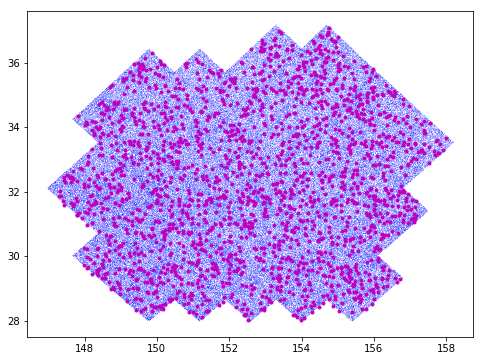

In [38]:
figure(figsize=(8,6))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.')

## Run fiberassign

First, generate fiberassign configuration files pointing to the right inputs/outputs

In [39]:
#- Write list of tiles to consider
dx = open(fibassigndir+'/dark-tiles.txt', 'w')
bx = open(fibassigndir+'/bright-tiles.txt', 'w')
for tileid, program  in zip(xtiles['TILEID'], xtiles['PROGRAM']):
    if program == 'BRIGHT':
        bx.write(str(tileid)+'\n')
    else:
        dx.write(str(tileid)+'\n')

dx.close()
bx.close()

#- Generate config files for dark and bright
cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-dark.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/dark-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-dark.txt".format(fibassigndir)
print(cmd)
!$cmd

cmd = "config-fiberassign "
cmd += " --mtl {}/mtl.fits".format(targetdir)
cmd += " --stdstars {}/standards-bright.fits".format(targetdir)
cmd += " --sky {}/sky.fits".format(targetdir)
cmd += " --surveytiles {}/bright-tiles.txt".format(fibassigndir)
cmd += " --outdir {}".format(fibassigndir)
cmd += " --config {}/fiberassign-config-bright.txt".format(fibassigndir)
print(cmd)
!$cmd

config-fiberassign  --mtl /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-dark.fits --sky /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/dark-tiles.txt --outdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign-config-dark.txt
config-fiberassign  --mtl /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/mtl.fits --stdstars /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/standards-bright.fits --sky /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/sky.fits --surveytiles /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/bright-tiles.txt --outdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --config /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign-config-bright.tx

#### Now run fiberassign itself ####
runs in <20 seconds for this subset of tiles

In [40]:
!rm -f $fibassigndir/tile_*.fits
!time fiberassign $fibassigndir/fiberassign-config-dark.txt > $fibassigndir/fa-dark.log
!time fiberassign $fibassigndir/fiberassign-config-bright.txt > $fibassigndir/fa-bright.log
!echo $(ls $fibassigndir/tile*.fits | wc -l) tile files created


real	0m5.566s
user	0m3.026s
sys	0m2.465s

real	0m5.959s
user	0m2.690s
sys	0m3.251s
22 tile files created


#### Run fiberassign QA ####
This will find non-fatal errors with unassigned fibers and too few standards

In [41]:
!qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits

/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01148.fits - ERROR
  Petal 3 has 7/10 stdstars
  Petal 4 has 8/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01149.fits - ERROR
  1 unassigned fibers
  Petal 3 has 7/10 stdstars
  Petal 9 has 7/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01165.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_06911.fits - ERROR
  Petal 0 has 7/10 stdstars
  Petal 5 has 9/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_06927.fits - ERROR
  Petal 4 has 8/10 stdstars
  Petal 5 has 7/10 stdstars
  Petal 8 has 9/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_11108.fits - ERROR
  Petal 8 has 9/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_12689.fits - ERROR
  1 unassigned fibers
  Petal 1 has 8/10 stdstars
  Petal 8 has 8/10 stdstars
  Petal 9 has 6/10 stdstars
/global/cscrat

## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

Setup the problem and define the commands to run, but then run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

7.4 minutes for 21 arc, 21 flat, 36 science exposures on 15 nodes.

In [53]:
# cmd = "srun -N 4 -n 4 -c 32 -C haswell -p debug -t 00:30:00 --qos premium "
nodes = 15

print('#- From a cori login node, set environment variables')
print('#- (you may have already done this from a previous step)')
print(envcmd)

print('#- Get an interactive job')
print('salloc -N {nodes} -C haswell -t 0:30:00 --qos interactive'.format(nodes=nodes))
print()

cmd = "srun -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
cmd += " --mockdir {}".format(targetdir)
cmd += " --obslist {}/exposures.fits".format(surveydir)
cmd += " --tilefile {}".format(tilefile)
print('#- Then run this in the interactive job')
print(cmd)

#- From a cori login node, set environment variables
#- (you may have already done this from a previous step)
source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=$SCRATCH/desi/dev/end2end
export DESISURVEY_OUTPUT=$basedir/survey
export DESI_SPECTRO_REDUX=$basedir/spectro/redux
export DESI_SPECTRO_SIM=$basedir/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=$DESI_SPECTRO_SIM/$PIXPROD

#- Get an interactive job
salloc -N 15 -C haswell -t 0:30:00 --qos interactive

#- Then run this in the interactive job
srun -N 15 -n 15 -c 32 wrap-newexp --mpi --fiberassign /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --obslist /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/exposures.fits --tilefile /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/test-tiles.fits


## Run fastframe to generate noisy uncalibrated spectra

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

9.6 minutes for 21 arc, 21 flat, 36 science exposures on 15 nodes

In [55]:
cmd = "srun -N {nodes} -n {nodes} -c 32 wrap-fastframe --mpi".format(nodes=nodes)
print('#- From the same interactive job where you ran wrap-newexp, run this:')
print(cmd)

#- From the same interactive job where you ran wrap-newexp, run this:
srun -N 15 -n 15 -c 32 wrap-fastframe --mpi


## Run the spectro pipeline

  * generate the production scripts
  * launch them

The pipeline massively overestimates the time to run each step, so at submission time dial the time back to just 10 minutes.

In [56]:
#- Equivalent to running `desi_pipe` from the command line with no arguments
#- Detail: have to provide blank string or otherwise it uses sys.argv which has
#- leftover args from launching jupyter
from desispec.scripts import pipe_prod
args = pipe_prod.parse('--nersc_host cori --nersc_queue debug --fakepix'.split())
pipe_prod.main(args)

/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Working with production /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini :
  Updating plans ...
  Creating setup.sh ...
  Selecting nights ...
  Finding max processes supported by workers ...
    bootstrap : 1 processes per task
    psf : 20 processes per task
    psfcombine : 1 processes per task
    extract : 20 processes per task
    fiberflat : 1 processes per task
    sky : 1 processes per task
    stdstars : 1 processes per task
    fluxcal : 1 processes per task
    calibrate : 1 processes per task
    redshift : 16 processes per task
  Generating scripts ...
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
65 minutes too big

In [57]:
#- Find nights that observed these tiles
nights = unique(np.char.replace(np.char.decode(explist['night']), '-', ''))
print(nights)

['20200315' '20200316' '20200318' '20200319' '20200320' '20200321'
 '20200322']


In [58]:
for night in nights:
    launchcmd = 'sbatch --time 00:10:00 {reduxdir}/run/scripts/{night}/fiberflat-calibrate_{night}.slurm'.format(
        reduxdir=reduxdir, night=night
    )
    print(launchcmd)
    err = subprocess.call(launchcmd.split())
    if err != 0:
        print('ERROR {} while launching {}'.format(err, night))

sbatch --time 00:10:00 /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200315/fiberflat-calibrate_20200315.slurm
sbatch --time 00:10:00 /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200316/fiberflat-calibrate_20200316.slurm
sbatch --time 00:10:00 /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200318/fiberflat-calibrate_20200318.slurm
sbatch --time 00:10:00 /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200319/fiberflat-calibrate_20200319.slurm
sbatch --time 00:10:00 /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200320/fiberflat-calibrate_20200320.slurm
sbatch --time 00:10:00 /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200321/fiberflat-calibrate_20200321.slurm
sbatch --time 00:10:00 /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200322/fiberflat-calibrate_

### Monitor those jobs until they have all completed

In [63]:
qq = 'squeue -u {}'.format(os.getenv('USER'))
!$qq

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7368525   regular fiberfla sjbailey PD       0:00     25 (Resources)
           7368528   regular fiberfla sjbailey  R       0:32     14 nid00[816-819,821,867-869,872-875,884-885]
           7368527   regular fiberfla sjbailey  R       2:33     12 nid00[787-792,794,797,804,810-811,813]
           7368526   regular fiberfla sjbailey  R       3:35     14 nid[12675,12677-12678,12686,12693,12736,12814-12815,12818-12820,12822,12851,12963]
           7368532   regular fiberfla sjbailey  R       4:49      2 nid0[1207,1301]
           7368529   regular fiberfla sjbailey  R       5:40      2 nid00[991-992]
           7368530   regular fiberfla sjbailey  R       5:40      2 nid[12976-12977]


### Check that we got expected outputs
This includes both calibration and science exposures

In [65]:
ii = np.in1d(explist['tileid'], xtiles['TILEID'])
nsci = len(explist[ii])
nflat = 3*len(nights)
nframe = 30*(nsci+nflat)
ncframe = 30*nsci
framefiles = sorted(glob.glob('{}/exposures/*/*/frame*.fits'.format(reduxdir)))
cframefiles = sorted(glob.glob('{}/exposures/*/*/cframe*.fits'.format(reduxdir)))
print('frame {}/{}, cframe {}/{}'.format(len(framefiles), nframe, len(cframefiles), ncframe))

frame 1710/1710, cframe 1080/1080


## Regroup spectra from frames -> healpix

This script is asking for 1 node for 2 hours (!).  Try running as interactive job on 10 nodes.  That took ~40 minutes.

Retrospective Note: the code probably uses 1 rank per healpix, in which case 160 ranks is a waste for ~70 healpix...

In [67]:
#- Equivalent to running `desi_group_spectra --hpxnside 64` from command line (this is slow)
# from desispec.scripts import group_spectra
# args = group_spectra.parse('--hpxnside 64'.split())
# group_spectra.main(args)

#- To run as a batch job instead (including MPI parallelism)

print('#- From a cori.nersc.gov login node with environment set as for previous interactive jobs')
print('salloc -N 10 -t 1:00:00 -C haswell --qos interactive')
print('export TMPDIR=/dev/shm')
print('srun --cpu_bind=cores -N 10 -n 160 -c 4 desi_group_spectra --pipeline')
# cmd = 'sbatch {}/run/scripts/spectra.slurm'.format(reduxdir)
# print(cmd)
# !$cmd

#- From a cori.nersc.gov login node with environment set as for previous interactive jobs
salloc -N 10 -t 1:00:00 -C haswell --qos interactive
export TMPDIR=/dev/shm
srun --cpu_bind=cores -N 10 -n 160 -c 4 desi_group_spectra --pipeline


## Did all pixels make it from sims -> output spectra?

It looks like tiles2pix was conservative and included some edge pixels that weren't
really necessary.

Missing spectra-64-5265.fits
Missing spectra-64-5268.fits
Missing spectra-64-5324.fits
Missing spectra-64-5636.fits


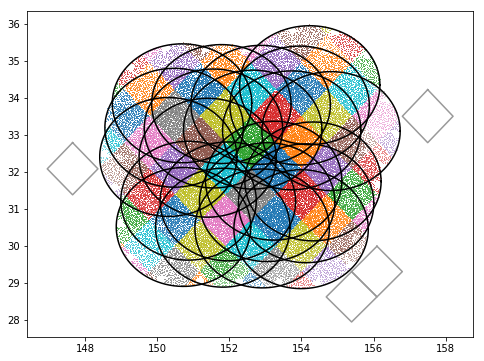

In [68]:
import desispec.io
nside=64
misspix = list()
figure(figsize=(8,6))
for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))
    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['RA_TARGET'], fibermap['DEC_TARGET'], ',', alpha=0.5)

plot_healpix(nside, misspix)
for t in xtiles:
    plot_tile(t['RA'], t['DEC'])

## Run redrock redshift fitting

desispec/0.16.0 has a bug in how spectra are distributed over MPI ranks for the pipeline wrapper of redrock.
Bypass this by using the `two_percent_DESI/mini/wrap-redrock` script.
```
# on a cori.nersc.gov login node,
# execute the environment setup commands at the beginning of this notebook (output of code cell #2)
# cd to your git repo for two_percent_DESI/mini, then run
salloc -N 15 -t 2:00:00 -C haswell --qos interactive
time srun -N 15 -n 15 -c 64 ./wrap-redrock --mpi --ncpu 24
```

### Check redrock output

In [9]:
import desitarget.io
zbestfiles = list(desitarget.io.iter_files(reduxdir, 'zbest'))
print('{} zbest files'.format(len(zbestfiles)))

67 zbest files


#### Sort bricks by number of targets

In [13]:
import desispec.io

specdir = os.path.join(os.getenv('DESI_SPECTRO_REDUX'), os.getenv('SPECPROD'), 'spectra-64')
specfiles = list()
print('specfile  nspec  ntargets')
for specfile in sorted(list(desitarget.io.iter_files(specdir, 'spectra'))):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm)
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )
    print(os.path.basename(specfile), nspec, ntarg)


specfile  nspec  ntargets
spectra-64-5261.fits 148 146
spectra-64-5262.fits 149 97
spectra-64-5263.fits 1616 1185
spectra-64-5266.fits 139 139
spectra-64-5267.fits 610 544
spectra-64-5270.fits 1070 743
spectra-64-5271.fits 577 333
spectra-64-5272.fits 1324 1189
spectra-64-5273.fits 3232 2008
spectra-64-5274.fits 4230 2508
spectra-64-5275.fits 6221 3156
spectra-64-5276.fits 3916 2047
spectra-64-5277.fits 2783 1527
spectra-64-5278.fits 5397 2741
spectra-64-5279.fits 4705 2524
spectra-64-5281.fits 38 19
spectra-64-5283.fits 158 79
spectra-64-5284.fits 1291 737
spectra-64-5285.fits 3515 1914
spectra-64-5286.fits 1753 907
spectra-64-5287.fits 3426 1888
spectra-64-5289.fits 16 8
spectra-64-5292.fits 1192 597
spectra-64-5293.fits 3032 1780
spectra-64-5294.fits 40 39
spectra-64-5295.fits 1325 907
spectra-64-5296.fits 5982 2960
spectra-64-5297.fits 7343 3753
spectra-64-5298.fits 5715 3175
spectra-64-5299.fits 7900 3831
spectra-64-5300.fits 7357 3713
spectra-64-5301.fits 6558 3202
spectra-64-530

## Create zcatalog

**TODO**: fix trailing space in TRUESPECTYPE, SPECTYPE

In [15]:
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {reduxdir}/zcatalog.fits'.format(reduxdir=reduxdir)
print(cmd)
!$cmd

desi_zcatalog -i /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/spectra-64 -o /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/zcatalog.fits


In [16]:
## Redshift QA
truth = Table.read(targetdir+'/truth.fits')
zcat = Table.read(reduxdir+'/zcatalog.fits')

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

In [17]:
import astropy.table
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [18]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')
print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  4993
LRG  9060
ELG  34400
STAR 8136
BGS  29989


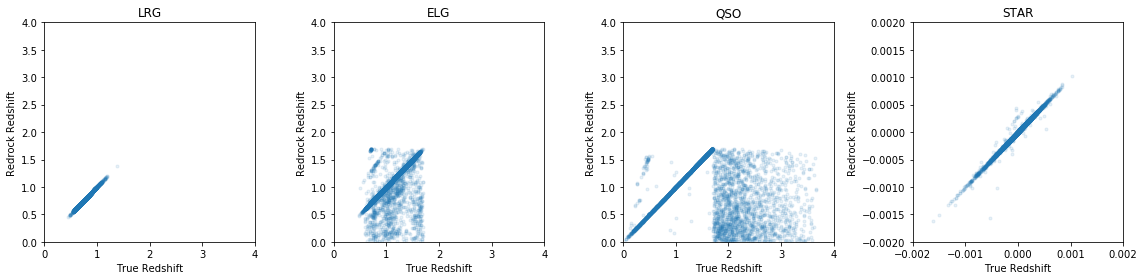

In [24]:
def plotz(ztruth, label, zmin=0.0, zmax=1.5, ylabel_=None):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.1)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)
    xlabel('True Redshift')
    ylabel('Redrock Redshift')

figure(figsize=(16,4))
subplot(141); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(142); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(143); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(144); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)
tight_layout()

In [41]:
def zstats(zx, dvlimit=1000, count=False):
    dv = 1e5 * (zx['Z'] - zx['TRUEZ'])/(1+zx['TRUEZ'])
    good = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] == 0)
    fail = (np.abs(dv)> dvlimit) & (zx['ZWARN'] == 0)
    miss = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] != 0)
    lost = (np.abs(dv)> dvlimit) & (zx['ZWARN'] != 0)
    ngood = np.count_nonzero(good)
    nfail = np.count_nonzero(fail)
    nmiss = np.count_nonzero(miss)
    nlost = np.count_nonzero(lost)
    ntot = len(dv)
    assert(ntot == ngood+nfail+nmiss+nlost)
    if count:
        return ngood, nfail, nmiss, nlost
    elif ntot == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        return 100*ngood/ntot, 100*nfail/ntot, 100*nmiss/ntot, 100*nlost/ntot

print('          ntarg   good  fail  miss  lost')
for objtype in set(ztruth['TEMPLATETYPE']):
    isx = (ztruth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost = zstats(ztruth[isx])
    nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

          ntarg   good  fail  miss  lost
ELG       34400   92.1   0.3   4.0   3.6
QSO        4993   60.2   2.2   1.0  36.7
WD          175   90.9   8.0   0.6   0.6
BGS       29989   99.8   0.1   0.1   0.0
LRG        9060  100.0   0.0   0.0   0.0
STAR       8136   91.3   0.3   1.3   7.1

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift ZWARN!=0 (missed opportunities)
lost = wrong redshift ZWARN!=0 (wrong but at least we know it)


## What happened to the high-z QSOs?

This is a bug in the QSO template generation in desispec 16.0

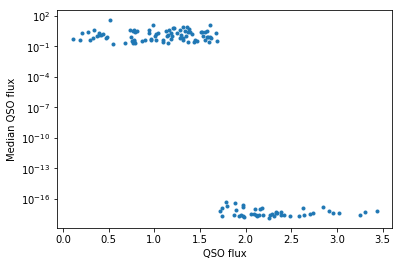

In [54]:
targetfile = targetdir+'/53/5300/truth-64-5300.fits'
xflux = fits.getdata(targetfile, 'FLUX')
xtrue = Table.read(targetfile, 'TRUTH')
isqso = xtrue['TRUESPECTYPE'] == 'QSO'
xflux = xflux[isqso]
xtrue = xtrue[isqso]
tmpflux = np.median(xflux, axis=1)

plot(xtrue['TRUEZ'], tmpflux, '.')
semilogy()
xlabel('QSO flux'); ylabel('Median QSO flux')

## Study QSO efficiency vs. FLUX_G

The failures are dominated by z>1.7 input spectra with the wrong flux units, but the lowz QSOs
are so efficient that is isn't very meaningful to bin them.  Leaving this code in here for now in case it is useful in a later update.

In [59]:
g = ztruth['FLUX_G']
magbins = np.linspace(16, 24, 17)
midmag = 0.5*(magbins[0:-1] + magbins[1:])
zeff = list()
for i in range(len(magbins)-1):
    maglo, maghi = magbins[i:i+2]
    ismag = (maglo < g) & (g < maghi)
    pgood, pfail, pmiss, plost = zstats(ztruth[isQSO & ismag])
    nmag = np.count_nonzero(isQSO & ismag)
    print('{:.1f}-{:.1f} {:4d} {:6s} {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(maglo, maghi, nmag, 'QSO', pgood, pfail, pmiss, plost))
    zeff.append(pgood)


16.0-16.5   18 QSO    100.0   0.0   0.0   0.0
16.5-17.0   15 QSO     66.7  13.3   0.0  20.0
17.0-17.5   10 QSO     80.0   0.0   0.0  20.0
17.5-18.0    9 QSO     88.9   0.0   0.0  11.1
18.0-18.5   13 QSO     84.6   7.7   7.7   0.0
18.5-19.0    9 QSO     77.8   0.0   0.0  22.2
19.0-19.5   12 QSO     75.0   0.0   0.0  25.0
19.5-20.0    7 QSO     85.7   0.0   0.0  14.3
20.0-20.5   13 QSO     92.3   0.0   0.0   7.7
20.5-21.0   12 QSO     91.7   0.0   0.0   8.3
21.0-21.5    7 QSO     85.7   0.0   0.0  14.3
21.5-22.0    9 QSO     77.8   0.0   0.0  22.2
22.0-22.5    7 QSO     85.7   0.0   0.0  14.3
22.5-23.0    8 QSO    100.0   0.0   0.0   0.0
23.0-23.5    7 QSO     85.7   0.0   0.0  14.3
23.5-24.0   14 QSO     71.4  14.3   0.0  14.3


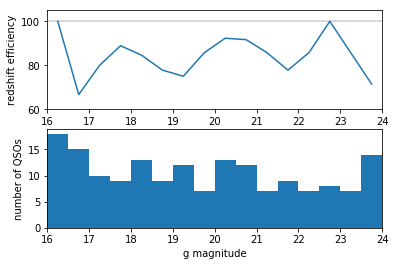

In [60]:
subplot(211)
axhline(100, color='0.8')
plot(midmag, zeff)
xlim(magbins[0], magbins[-1])
ylabel('redshift efficiency')
ylim(60,105)

subplot(212)
hist(g[isQSO], len(magbins)-1, (magbins[0], magbins[-1]))
xlim(magbins[0], magbins[-1])
xlabel('g magnitude')
ylabel('number of QSOs')

# TODO

A wishlist of things to add to this notebook (but not necessarily blocking factors for merging)
* Target selection QA
* spectro pipeline QA
* other QA?